In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import os
from mido.midifiles.meta import KeySignatureError
from mido import MidiFile
import mido
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from functools import partial
from copy import deepcopy
from base import BaseModel
from datasets import load_rolls, MotifDataset, roll_to_monoroll
from models import MonophonicTransformer
from utils import roll_to_midi

There were 486 rolls with non-4/4 signatures
834 rolls were loaded from 910 files


<AxesSubplot:>

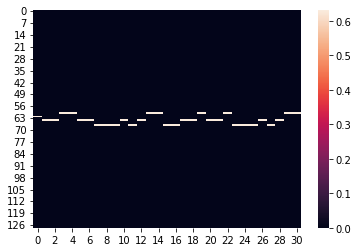

In [2]:
test_path = 'samples/music/flute/'
rolls, tpb = load_rolls(test_path)
sn.heatmap(rolls[12])

In [3]:
motif_size = 32
bits = 16
paths = [
    # 'samples/music/giantpiano/',
    'samples/music/flute/',
    # 'samples/music/jazz/',
#     'samples/music/maestro/',
    # 'samples/music/mfiles/',
    # 'samples/music/midiworld/',
]
dataset = MotifDataset(paths, motif_size=motif_size, bits=bits, notespbeat=20, monophonic=True)

452 piano rolls loaded with [00, 01] - 0.973 ± 0.161 maximum consecutive notes


In [4]:
dataset[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

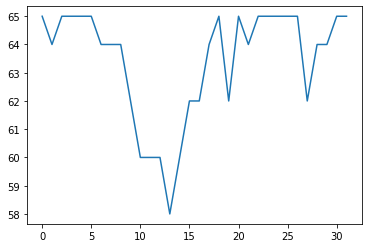

In [5]:
r = dataset[20][0]
# sn.heatmap(r)
# r = roll_to_monoroll(r)
r = [x if x > 0 else np.nan for x in r]
plt.plot(range(len(r)), r)

In [6]:
r = dataset.rolls[88]
r.shape
dataset.keys[88]

'F'

In [7]:
batch_size = 16

net_multi = MonophonicTransformer(encoder_depth=128, decoder_depth=128, heads=16)
n_param = sum(
    p.numel() for p in net_multi.parameters() if p.requires_grad
)
print('Network ready {:d} parameters'.format(n_param))

train_loader = DataLoader(
    dataset, batch_size, True, num_workers=1
)
val_loader = DataLoader(
    dataset, batch_size, num_workers=1
)

net_multi.fit(train_loader, val_loader, epochs=10, patience=10)

Network ready 299264 parameters


/home/brendan/OneDrive/Masters/BrainHack2022/brainharmonic/models.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.transpose(0, 1), dtype=int)


tensor([[ 0,  0,  0,  0,  0,  0,  0, 55, 59,  0,  0,  0, 66,  0, 67, 59],
        [ 0, 67, 65,  0,  0,  0,  0, 62, 62,  0,  0,  0, 66,  0,  0, 59],
        [67, 67, 65,  0, 67,  0,  0, 60, 62,  0,  0,  0, 66,  0, 62, 59],
        [ 0,  0,  0,  0, 67,  0,  0, 59, 62, 74,  0,  0,  0,  0,  0, 59],
        [ 0,  0,  0,  0, 67,  0,  0, 55, 67,  0,  0,  0, 66,  0,  0, 59],
        [66,  0, 65,  0, 67, 66,  0, 58, 64,  0,  0,  0,  0,  0, 62, 59],
        [66,  0, 65, 57, 67, 66,  0, 57, 64,  0,  0,  0, 64,  0, 65, 59],
        [ 0,  0,  0,  0,  0, 66,  0, 55, 64, 71,  0,  0, 64,  0, 70, 59],
        [ 0,  0,  0,  0,  0, 66,  0, 55, 59,  0,  0,  0, 64,  0,  0, 59],
        [64,  0, 65,  0,  0, 66,  0, 55, 62,  0,  0,  0,  0,  0, 74, 59],
        [64,  0, 65,  0, 71,  0,  0, 52, 62,  0,  0,  0,  0,  0,  0, 59],
        [64,  0,  0,  0, 67,  0,  0, 50, 62, 76,  0,  0,  0,  0,  0, 59],
        [ 0,  0,  0,  0,  0, 66,  0, 52, 62,  0,  0,  0, 64,  0, 77, 59],
        [74,  0,  0,  0,  0, 66, 48, 5

RuntimeError: "LayerNormKernelImpl" not implemented for 'Long'

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
net_multi.save_model('weights/all_multi.pt')

In [ ]:
net_multi = MonophonicTransformer(encoder_depth=128, decoder_depth=128, multitokens=True, heads=16)
net_multi.load_state_dict(torch.load('weights/all_multi.pt'))
net_multi.eval()

MusicTransformer(
  (encoder): ModuleList(
    (0): SelfAttentionBlock(
      (ln1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): Linear(in_features=128, out_features=128, bias=True)
    )
    (1): SelfAttentionBlock(
      (ln1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): SelfAttentionBlock(
      (ln1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_feature

In [ ]:
rand_idx = np.random.randint(0, len(rolls))
random_roll = rolls[rand_idx]
random_tpb = tpb[rand_idx]
random_motif = random_roll[:, :motif_size].astype(np.float32)
random_vel = np.mean(random_motif[random_motif > 0])
song = random_roll[:, :motif_size + motif_size] 

In [ ]:
p_song, pred_song = net_multi.song((random_motif > 0).astype(np.float32), 1)
plt.figure(figsize=(12, 18))
plt.subplot(3, 1, 1)
sn.heatmap(p_song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(3, 1, 2)
sn.heatmap(pred_song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(3, 1, 3)
sn.heatmap(song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

AttributeError: 'MonophonicTransformer' object has no attribute 'multitokens'

In [ ]:
tmpname = "/tmp/tmpmidi.mid"
roll_to_midi(os.path.dirname(tmpname), os.path.basename(tmpname), pred_song, random_tpb)
# mid = MidiFile(tmpname)
# port = mido.open_output('Midi Through Port-0')
# for msg in mid.play():
#     port.send(msg)

Note on 74 127 0
Note on 73 127 480
Note off 74
Note on 69 127 480
Note off 73
Note on 81 127 480
Note off 69
Note on 80 127 480
Note off 81
Note on 76 127 480
Note off 80
Note on 83 127 480
Note off 76
Note on 81 127 480
Note off 83
Note on 78 127 480
Note off 81
Note on 76 127 480
Note off 78
Note on 69 127 960
Note off 76
Note on 74 127 480
Note off 69
Note on 73 127 480
Note off 74
Note on 69 127 480
Note off 73
Note on 81 127 480
Note off 69
Note on 80 127 480
Note off 81
Note on 76 127 480
Note off 80
Note on 83 127 480
Note off 76
Note on 81 127 480
Note off 83
Note on 78 127 480
Note off 81
Note on 76 127 480
Note off 78
Note on 69 127 960
Note off 76
Note on 78 127 480
Note off 69
Note on 74 127 480
Note off 78
Note on 71 127 480
Note off 74
Note on 76 127 480
Note off 71
Note on 73 127 480
Note off 76
Note on 69 127 480
Note off 73
Note on 78 127 480
Note off 69
Note on 74 127 480
Note off 78
Note on 60 127 480
Note on 67 127 0
Note on 98 127 0
Note off 74
Note on 73 127 480


In [ ]:
pred_song

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)